In [51]:
import eegPinelineDesign
import numpy as np
import random
import mne
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import re
import json
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA,FastICA
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from scipy.fftpack import fft,ifft
import math
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from scipy.signal import spectrogram,find_peaks_cwt,butter, lfilter
from mne.preprocessing.ica import ICA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split,ShuffleSplit
from sklearn.preprocessing import label_binarize,scale
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize,StandardScaler
eegPinelineDesign.change_file_directory('C:/Users/ning/Downloads/training set')
EDFfiles, Annotationfiles = eegPinelineDesign.split_type_of_files()
from eegPinelineDesign import CenterAtPeakOfWindow,Threshold_test,spindle_overlapping_test,used_windows_check,cut_segments

['64chlocs.elp', 'label_extraction.npy', 'label_extraction.pkl', 'pineline 13.csv', 'pipe line 10', 'pipe line 10.csv', 'pipeline 13.pickle', 's5d2_final.edf', 's5d2_final_annotations.txt', 's6n2_final.edf', 's6n2_final_annotations.txt', 'single subject prediction.p', 'single subject.p', 'Sleep Stage Scoring Criteria.docx', 'spindle training.p', 'suj10_d1final.edf', 'suj10_d1final_annotations.txt', 'suj10_d2final.edf', 'suj10_d2final_annotations.txt', 'suj13_l2nap_day2 edited.edf', 'suj13_l2nap_day2 edited1.edf', 'suj13_l2nap_day2 edited1_annotations.txt', 'suj13_l2nap_day2 edited_annotations.txt', 'suj13_l2nap_day2 edited_C3.txt', 'suj13_l2nap_day2 edited_C4.txt', 'suj13_l2nap_day2 edited_F3.txt', 'suj13_l2nap_day2 edited_F4.txt', 'suj13_l2nap_day2 edited_O1.txt', 'suj13_l2nap_day2 edited_O2.txt', 'suj5_d1final.edf', 'suj5_d1final_annotations.txt', 'suj6_d1final.edf', 'suj6_d1final_annotations.txt', 'suj8_d1final.edf', 'suj8_d1final_annotations.txt', 'suj8_d2final.edf', 'suj8_d2final_

In [2]:
from eegPinelineDesign import CenterAtPeakOfWindow,Threshold_test,spindle_overlapping_test,used_windows_check,cut_segments


num=int(input())
spindle={};nonspindle={};time_spindle={};time_nonspindle={}
file_to_read,fileName=eegPinelineDesign.pick_sample_file(EDFfiles,n=num)
channelList = ['F3','F4','C3','C4','O1','O2','ROC','LOC']
raw = eegPinelineDesign.load_data(file_to_read,channelList,None, 100)#low pass data
raw_alpha=eegPinelineDesign.load_data(file_to_read,channelList,8, 12)#alpha pass
raw_spindle=eegPinelineDesign.load_data(file_to_read,channelList,11, 16)#spindle pass
raw_muscle=eegPinelineDesign.load_data(file_to_read,channelList,30, 40)#
annotation_to_read = [x for x in Annotationfiles if fileName in x]
file = pd.read_csv(annotation_to_read[0])
labelFind = re.compile('spindle',eegPinelineDesign.re.IGNORECASE)
spindles=[]# take existed annotations
for row in file.iterrows():
    currentEvent = row[1][-1]
    if labelFind.search(currentEvent):
        spindles.append(row[1][0])# time of marker
print('finish spindle annotation')

channelList=['F3','F4','C3','C4','O1','O2']
plt.figure(figsize=(20,20))
used_time_windows=[]
time_spindle[fileName]={};time_nonspindle[fileName]={}
spindle[fileName]={};nonspindle[fileName]={}
for channelID, names in enumerate(channelList):
    time_spindle[fileName][names]=[];time_nonspindle[fileName][names]=[]
    spindle[fileName][names]=[];nonspindle[fileName][names]=[]
    print(names)
    used_time_windows=[]
    for items in spindles:
        if Threshold_test(items,raw_alpha,raw_spindle,raw_muscle,channelID):
            try:
                centered_marker=CenterAtPeakOfWindow(items,2,raw_spindle,channelID)
                Segment,TT = cut_segments(raw_spindle,centered_marker,channelID)
                spindle[fileName][names].append(Segment)
                print(fileName,names,centered_marker,'spindle')
                #plt.plot(TT,Segment)
                #plt.clf()
                for max_iteration in range(1000):
                    startPoint=6;endPoint=raw.last_samp/1000-6
                    start,stop=raw.time_as_index([startPoint,endPoint])
                    S,T = raw[channelID,start:stop]
                    timePoint=np.random.choice(T,1)
                    if (Threshold_test(timePoint,raw_alpha,raw_spindle,raw_muscle,channelID)) and (spindle_overlapping_test(spindles,timePoint,1.5)) and (used_windows_check(timePoint,used_time_windows,1.5)):
                        Segment,_=cut_segments(raw_spindle,timePoint,channelID)
                        nonspindle[fileName][names].append(Segment)
                        used_time_windows.append([timePoint-1.5,timePoint+1.5])
                        print(timePoint,'non spindle')
                        break
                    else:
                        #print('no non spindle left')
                        pass
            except:
                print('error')
        else:
            pass

18


KeyboardInterrupt: 

In [ ]:
result={'spindle':spindle,'non spindle':nonspindle,'spindle time':time_spindle,'nonspindle time':time_nonspindle}
import pickle
with open('single subject.p','wb') as handle:
    pickle.dump(result,handle)

In [3]:
import pickle
with open('single subject.p','rb') as handle:
    result=pickle.load(handle)

In [4]:
fileName=list(result['spindle'].keys())[0]

In [5]:
channelList=['F3','F4','C3','C4','O1','O2']
X = [];Y=[]
for names in channelList:
    for item in result['spindle'][fileName][names]:
        if item.shape[1] == 3000:

            X.append(item[0,:])
            Y.append(1)
    for item in result['non spindle'][fileName][names]:
        if item.shape[1] == 3000:
            X.append(item[0,:])
            Y.append(0)

X=np.array(X);Y=np.array(Y)
print(X.shape,Y.shape)

(382, 3000) (382,)


In [6]:
idx=np.arange(X.shape[0])
GG=np.random.choice(tuple(idx),len(idx),replace=False)

XX=[];YY=[]
for idxx in GG:
    XX.append(X[idxx])
    YY.append(Y[idxx])

X_train, X_test, y_train, y_test = train_test_split(XX, YY, test_size=0.20)

print(y_train)

[1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0]


In [7]:
clf =LogisticRegression(penalty='l2',C=1,tol=10e-9,fit_intercept=True,solver='liblinear',
                                             max_iter=5e8,multi_class='ovr',n_jobs=-1)



clf.fit(X_train,y_train)
print(classification_report(clf.predict(X_test),y_test))
print(clf.score(X_train,y_train))

             precision    recall  f1-score   support

          0       1.00      0.44      0.61        77
          1       0.00      0.00      0.00         0

avg / total       1.00      0.44      0.61        77

0.514754098361


In [8]:
clf = SVC(C=1,kernel='rbf',tol=10e-9,max_iter=5e8)
clf.fit(X_train,y_train)
print(classification_report(clf.predict(X_test),y_test))
print(clf.score(X_train,y_train))

             precision    recall  f1-score   support

          0       1.00      0.44      0.61        77
          1       0.00      0.00      0.00         0

avg / total       1.00      0.44      0.61        77

0.514754098361


In [9]:
pca = PCA(n_components=.99,whiten=True)
X_pca=pca.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, YY, test_size=0.20)

clf =LogisticRegression(penalty='l2',C=1,tol=10e-9,fit_intercept=True,solver='liblinear',
                                             max_iter=5e8,multi_class='ovr',n_jobs=-1)



clf.fit(X_train,y_train)
print(classification_report(clf.predict(X_test),y_test))
print(clf.score(X_train,y_train))

             precision    recall  f1-score   support

          0       0.49      0.67      0.56        30
          1       0.72      0.55      0.63        47

avg / total       0.63      0.60      0.60        77

0.659016393443


In [11]:
clf = SVC(C=1,kernel='rbf',tol=10e-9,max_iter=5e8)
clf.fit(X_train,y_train)
print(classification_report(clf.predict(X_test),y_test))
print(clf.score(X_train,y_train))

             precision    recall  f1-score   support

          0       0.41      0.68      0.52        25
          1       0.78      0.54      0.64        52

avg / total       0.66      0.58      0.60        77

0.822950819672


[137]
1


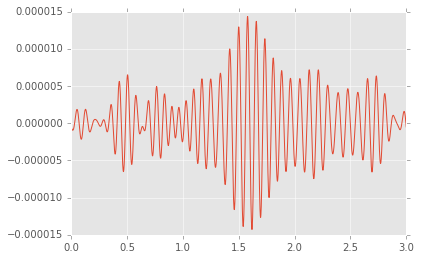

In [12]:
num=np.random.randint(0,X.shape[0],size=1)
print(num)
t = np.linspace(0,3,X.shape[1])
print(YY[num])
plt.plot(t,XX[num])

In [13]:
from sklearn.preprocessing import normalize

In [14]:
normal_X = normalize(XX)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(normal_X, YY, test_size=0.20)

#print(y_train)

clf =LogisticRegression(penalty='l2',C=.1,tol=10e-9,fit_intercept=True,solver='liblinear',
                                             max_iter=10e7,multi_class='ovr',n_jobs=-1)



clf.fit(X_train,y_train)
print('logistic,1 fold, 80/20 train/test slipt')
print(classification_report(clf.predict(X_test),y_test))
print('within training data set',clf.score(X_train,y_train))

logistic,1 fold, 80/20 train/test slipt
             precision    recall  f1-score   support

          0       0.95      1.00      0.97        36
          1       1.00      0.95      0.97        41

avg / total       0.98      0.97      0.97        77

within training data set 0.954098360656


In [ ]:
clf =LogisticRegression(penalty='l2',C=.1,tol=10e-9,fit_intercept=True,solver='liblinear',
                                             max_iter=10e7,multi_class='ovr',n_jobs=-1)
scores = cross_val_score(clf, normal_X,YY,cv=10)
#print(scores)
print(scores.mean())

In [ ]:
from sklearn.cross_validation import cross_val_predict
prediction = cross_val_predict(clf, normal_X,YY,cv=10)
print(accuracy_score(YY,prediction))

In [17]:
a,b,c=np.linalg.svd(normal_X)

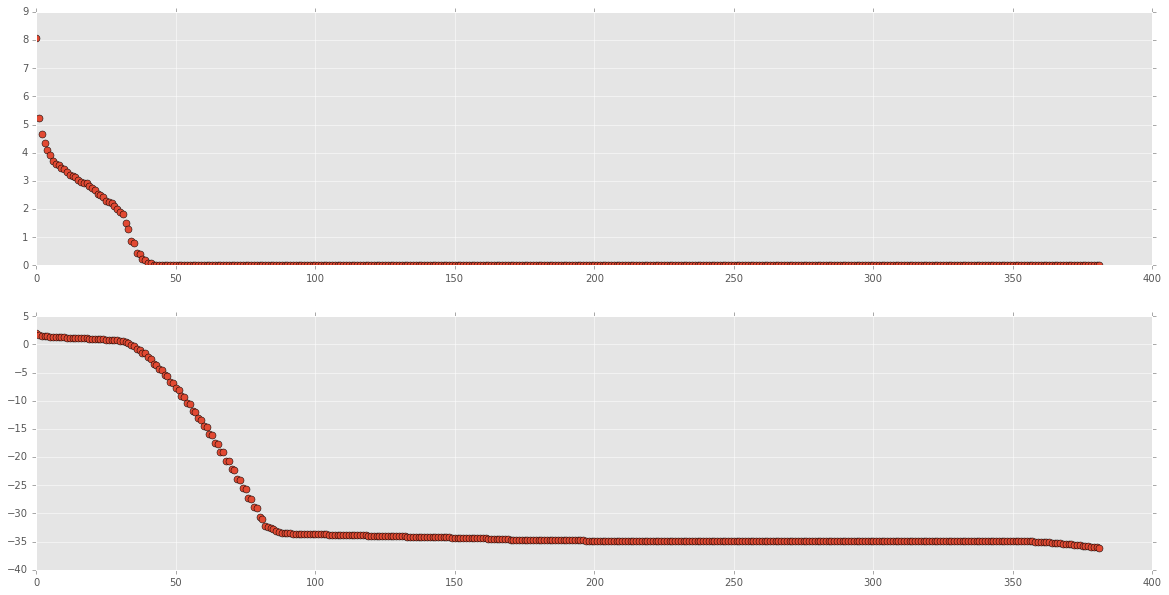

In [18]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(np.arange(len(b)),b,'o',markersize=7)
plt.subplot(2,1,2)
plt.plot(np.arange(len(b)),np.log(b),'o',markersize=7)

In [19]:
file_to_read=fileName+'.edf'
channelList = ['F3','F4','C3','C4','O1','O2','ROC','LOC']
raw_filter = eegPinelineDesign.load_data(file_to_read,channelList,11, 16)
raw_alpha=eegPinelineDesign.load_data(file_to_read,channelList,8, 12)#alpha pass
raw_spindle=eegPinelineDesign.load_data(file_to_read,channelList,11, 16)#spindle pass
raw_muscle=eegPinelineDesign.load_data(file_to_read,channelList,30, 40)#

Extracting edf Parameters from s6n2_final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 2073999  =      0.000 ...  2073.999 secs...
Ready.
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8
    Searching for artifacts...
    found 2 artifacts by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    2, 7, 4, 4, 2
    Removing duplicate indices...
Ready.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Band-pass filtering from 11 - 16 Hz
Extracting edf Parameters from s6n2_final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 2073999  =      0.000 ...  2073.999 secs...
Ready.
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA com

In [20]:
channelList = ['F3','F4','C3','C4','O1','O2']
raw_filter.pick_channels(channelList)

<RawEDF  |  s6n2_final.edf, n_channels x n_times : 6 x 2074000 (2074.0 sec)>

In [33]:
time_label={};resolution = 0.1
for ii,names in enumerate(channelList):
    time_label[names]=[]
    centerPoint = 0+5
    while raw_filter.last_samp/1000 - centerPoint > 1.5:
        print(centerPoint)
        if Threshold_test(centerPoint,raw_alpha,raw_spindle,raw_muscle,ii):
            centeredxval = CenterAtPeakOfWindow(centerPoint,2,raw_filter,ii)
            tempSegment,timeSpan=cut_segments(raw_filter,centeredxval,ii,windowsize = 1.5)
            predictedLabel = clf.predict(tempSegment)
            time_label[names].append([centeredxval,predictedLabel])
            
        
        centerPoint += resolution
print('done')

done


[[ 0.30279193  0.69720807]] 3000


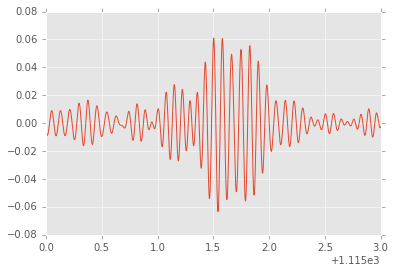

In [50]:
timepoint = 1116.5
Threshold_test(timepoint,raw_alpha,raw_spindle,raw_muscle,0)
tempSegment,timeSpan = cut_segments(raw_filter,timepoint,0,windowsize=1.5)
#centeredxval = CenterAtPeakOfWindow(timepoint,2,raw_filter,0)
#tempSegment,timeSpan = cut_segments(raw_filter,centeredxval,0,windowsize=1.5)
plt.plot(timeSpan,normalize(tempSegment[0,:])[0,:])
print(clf.predict_proba(normalize(tempSegment[0,:])),len(tempSegment[0,:]))

In [31]:
annotation_to_read = [x for x in Annotationfiles if fileName in x]
file = pd.read_csv(annotation_to_read[0])
labelFind = re.compile('spindle',eegPinelineDesign.re.IGNORECASE)
spindles=[]# take existed annotations
for row in file.iterrows():
    currentEvent = row[1][-1]
    if labelFind.search(currentEvent):
        spindles.append(row[1][0])# time of marker

In [32]:
print(spindles)

[462.785, 478.093, 571.373, 629.202, 639.38, 657.044, 1106.309, 1116.739, 1127.701, 1134.991, 1141.804, 1161.514, 1166.309, 1169.505, 1175.533, 1176.907, 1188.514, 1235.729, 1240.86, 1260.71, 1265.393, 1273.103, 1297.019, 1302.682, 1322.253, 1342.944, 1346.309, 1353.514, 1355.533, 1357.664, 1359.935271, 1364.645, 1373.337, 1381.467, 1390.131, 1423.187, 1426.524]


In [35]:
with open('single subject prediction.p','wb') as handle:
    pickle.dump(time_label,handle)

In [47]:
normalize(tempSegment[0,:]).shape

(1, 3000)

In [57]:
with open('single subject prediction.p','rb') as handle:
    time_label=pickle.load(handle)

In [58]:
time_label.keys()

dict_keys(['C4', 'O2', 'F4', 'O1', 'C3', 'F3'])

In [73]:
time_label_matrix = np.zeros([7,len(time_label['C4'])])

In [74]:
time_label_matrix[0,:]=np.array(time_label['C4'])[:,0]

In [76]:
for ii,names in enumerate(channelList):
    time_label_matrix[ii+1,:]=np.array(time_label[names])[:,1]

ValueError: could not broadcast input array from shape (28059) into shape (31002)